# Palestinian prisoners to be released in the November 2023 temporary truce deal
The data published by the Israeli department of justice is used here ([link](https://www.gov.il/he/Departments/DynamicCollectors/is-db?skip=0))

The data is taken from the automatically translated (Google Translate) website from Hebrew. Therefore, translations may not be precise.

In [1]:
import re
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading data
with open("data/prisoners.jsons", "r") as f:
    all_prisoner_data = [json.loads(line) for line in f.readlines()]

In [3]:
df = pd.DataFrame(all_prisoner_data)

In [4]:
def convert_sentence_to_days(sentence):

    if "-" not in sentence:
        return 0
    
    years, months, days = [x for x in sentence.split("-") if x != ""]
    years = int(years)
    months = int(months)
    days = int(days)

    return years * 365 + months * 30 + days

def clean_prisoner_data(data):
    df = data.copy()

    # Converting to datetime
    cols = ["birth_date", "arrest_date"]
    for col in cols:
        df[col] = pd.to_datetime(df[col], format="%d.%m.%Y")

    # Converting sentence to days
    df["sentence"] = df["sentence"].apply(convert_sentence_to_days)
    df['sentence'] = df['sentence'].astype(int)

    # Age at arrest
    df["age_at_arrest"] = df["arrest_date"] - df["birth_date"]
    df["age_at_arrest"] = df["age_at_arrest"].apply(lambda x: x.days // 365)

    return df

In [5]:
df = clean_prisoner_data(df)

## Age at the time of arrest

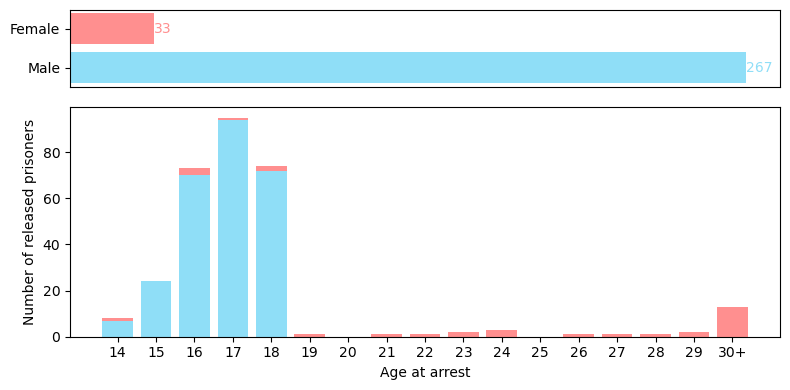

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(8, 4), gridspec_kw={"height_ratios": [1, 3]}, tight_layout=True)

gender_color = {
    'male': '#8fdef7',
    'female': '#ff8f8f'
}
alpha = 1

# Plotting gender distribution
ax = axs[0]
graph_data = df['gender'].value_counts()
graph_data.index = graph_data.index.map(lambda x: x.capitalize())
ax.barh(y=graph_data.index, width=graph_data.values,
        color=[gender_color['male'], gender_color['female']], alpha=alpha)

# Add text of count next to each bar
for i, (count, color) in enumerate(zip(graph_data.values, [gender_color['male'], gender_color['female']])):
    ax.text(x=count, y=i, s=count, ha='left', va='center', color=color)

# ax.set_xlabel("Number of released prisoners")
ax.set_xticks([])

# Plotting No. of prisoners by age at arrest
ax = axs[1]
age_at_arrest = df["age_at_arrest"].value_counts().sort_index()
min_age = age_at_arrest.index.min()
max_age = age_at_arrest.index.max()
age_limit = 30

xticks = np.arange(min_age, age_limit+1)
xtickslabels = [str(x) for x in xticks]
xtickslabels[-1] = f"{age_limit}+"
ax.set_xticks(xticks)
ax.set_xticklabels(xtickslabels)
ax.set_xlabel("Age at arrest")
ax.set_ylabel("Number of released prisoners")

# Plotting prisoners by gender
bottom = None
for gender, color in gender_color.items():
    cond = df['gender'] == gender
    age_at_arrest = df[cond]["age_at_arrest"].value_counts().sort_index()
    graph_data = pd.Series(index=np.arange(min_age, max_age + 1), data=0)
    graph_data.update(age_at_arrest)

    cond = graph_data.index >= age_limit
    x = graph_data[~cond].index.tolist() + [age_limit]
    y = graph_data[~cond].values.tolist() + [graph_data[cond].sum()]
    ax.bar(x=x, height=y, color=color, alpha=alpha, bottom=bottom, label=gender.capitalize())
    if bottom is None:
        bottom = y

# ax.legend()

# plt.savefig('figures/age_at_arrest.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Pretrial detainees

In [7]:
release_date = pd.to_datetime("2023-11-24")
df['time_served'] = release_date - df['arrest_date']
df['time_served'] = df['time_served'].apply(lambda x: x.days)
cond = df['sentence'] > 0
df['sentenced'] = 'Sentenced'
df.loc[~cond, 'sentenced'] = 'Under arrest'

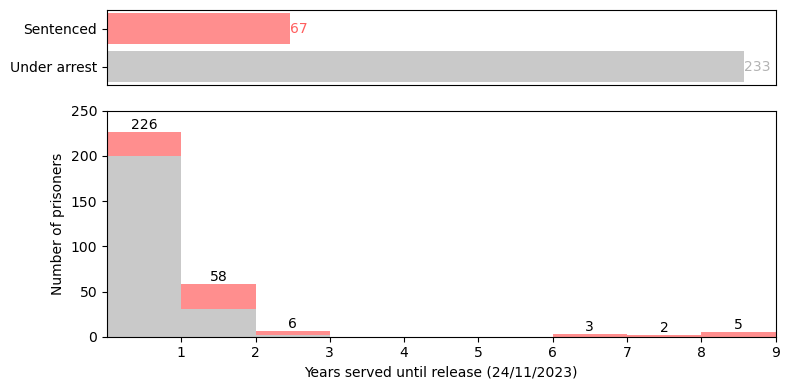

In [8]:
colors = {
    'Under arrest': '#b3b3b3',
    'Sentenced': '#ff5e5e'
}
bin_count = 10
alpha = 0.7

fig, axs = plt.subplots(2, 1, figsize=(8, 4), gridspec_kw={"height_ratios": [1, 3]}, tight_layout=True)

# Plotting sentenced/under arrest
ax = axs[0]
graph_data = df['sentenced'].value_counts()
graph_data.index = graph_data.index.map(lambda x: x.capitalize())
ax.barh(y=graph_data.index, width=graph_data.values,
        color=[colors['Under arrest'], colors['Sentenced']], alpha=alpha)

# Add text of count next to each bar
for i, (count, color) in enumerate(zip(graph_data.values, [colors['Under arrest'], colors['Sentenced']])):
    ax.text(x=count, y=i, s=count, ha='left', va='center', color=color)

# ax.set_xlabel("Number of released prisoners")
ax.set_xticks([])

ax = axs[1]
bins = np.arange(0, 365*bin_count, 365)
g = sns.histplot(x='time_served', data=df, hue_order=['Sentenced', 'Under arrest'], edgecolor='none',
             hue='sentenced', bins=bins, ax=ax, alpha=alpha, multiple="stack", palette=colors, log_scale=False)

ax.set_xlabel("Years served until release (24/11/2023)")
ax.set_ylabel("Number of prisoners")



time_arr = [365*i for i in range(1, 10)]
time_labels = [x // 365 for x in time_arr]
ax.set_xticks(time_arr)
ax.set_xticklabels(time_labels)

# Add text of count over each bar
counts, bins = np.histogram(df['time_served'], bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
for x, y in zip(bin_centers, counts):
    if y == 0:
        continue
    ax.text(x, y=y, s=y, ha='center', va='bottom', color='black')
ax.minorticks_off()

g.legend_.remove()
ax.set_ylim(0, 250)
ax.set_xlim(0, 365*(bin_count - 1))

# plt.savefig('figures/time_served.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Sentences of convicts

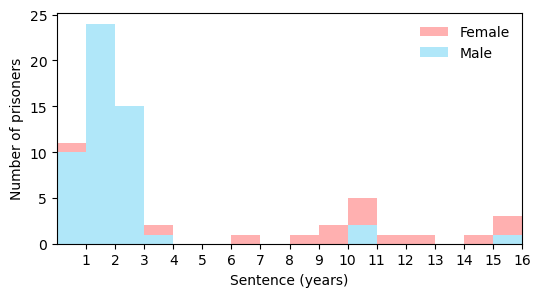

In [9]:
gender_color = {
    'Male': '#8fdef7',
    'Female': '#ff8f8f'
}
# Number of years
bin_count = 17

cond = df['sentence'] > 0
graph_data = df.loc[cond].copy()
graph_data['gender'] = graph_data['gender'].map(lambda x: x.capitalize())

fig, ax = plt.subplots(figsize=(6, 3))

bins = np.arange(0, 365*bin_count, 365)
g = sns.histplot(x='sentence', data=graph_data, edgecolor='none', hue='gender', hue_order=['Female', 'Male'],
              bins=bins, ax=ax, alpha=0.7, palette=gender_color, log_scale=False,  multiple="stack",)

time_arr = [365*i for i in range(1, bin_count)]
time_labels = [x // 365 for x in time_arr]
ax.set_xticks(time_arr)
ax.set_xticklabels(time_labels)

ax.set_xlabel("Sentence (years)")
ax.set_ylabel("Number of prisoners")

g.legend_.set_title(None)
g.legend_.set_frame_on(False)

ax.set_xlim(0, 365*(bin_count - 1))

# plt.savefig('figures/sentence.pdf', dpi=300, bbox_inches='tight')
plt.show()


## Exploring charges

In [10]:
df['num_offenses'] = df['offense'].apply(lambda x: len(x.split(", ")))

In [11]:
all_offenses = sum(df['offense'].apply(lambda x: x.split(", ")), [])
all_offenses = list(map(lambda x: x.strip().lower(), all_offenses))
all_offenses = pd.Series(all_offenses)

# Replacing similar offenses with a common name
offense_map = {
    # Bodily harm
    'grievous bodily harm': 'bodily harm',
    'serious bodily harm': 'bodily harm',
    'serious bodily injury': 'bodily harm',

    # Throwing a bomb
    'throwing a bomb': 'throwing a bomb',
    'throwing a bomb or an arsonist': 'throwing a bomb',
    'throwing a bomb or an incendiary': 'throwing a bomb',
    'throwing a bomb or an incendiary device': 'throwing a bomb',
    'throwing a bomb or incendiary': 'throwing a bomb',

    # Throwing stones
    'handing stones': 'throwing stones',
    'stone spraying': 'throwing stones',
    'stone throwing': 'throwing stones',
    'throwing stones': 'throwing stones',

    # Security offenses
    'damage to the security of the area': 'security offense',
    'damage to the security of the region': 'security offense',
    'harming the security of the area': 'security offense',
    'security offenses - equipment': 'security offense',
    'state security - another': 'security offense',
    'state security - other': 'security offense',
    'state security offenses': 'security offense',

    # Casusing death
    'attempt to cause death on purpose': 'attempt to cause death',
    'causing death on purpose': 'causing death',
    'intentionally causing death': 'causing death',
    'connection to causing death on purpose': 'connection to causing death',
    'connection to causing death with intent': 'connection to causing death',
    'involvement in causing death on purpose': 'connection to causing death',
    'conspiracy to cause death on purpose': 'conspiracy to cause death',
    'conspiracy to cause death with intent': 'conspiracy to cause death',

    # Damage to property
    'causing damage to property maliciously or negligently': 'malicious or negligent damage to property',
    'damage/ammunition/explosives': 'malicious or negligent damage to property',
    'malicious or negligent damage to property': 'malicious or negligent damage to property',
    'maliciously or negligently causing damage to property': 'malicious or negligent damage to property',
    
    # Illegal crimes
    'anti-military crimes': 'illegal crimes',
    'connection to the commission of a crime': 'involvement in the commission of a crime',
    'involvement in the commission of a crime': 'involvement in the commission of a crime',
    'conspiracy to commit a crime': 'involvement in the commission of a crime',
    'crimes': 'illegal crimes',
    'crimes against human life': 'crimes against humanity',
    'crimes against humanity': 'crimes against humanity',
    'crimes against justice': 'illegal crimes',
    'crimes against law': 'illegal crimes',
    'crimes against public order': 'illegal crimes',
    'crimes against the law': 'illegal crimes',
    'illegal crimes': 'illegal crimes',
    'illegal crimes (defense measures)': 'illegal crimes',

    # Supporting terrorism
    'support for terrorism': 'supporting terrorism',
    'supporting terrorism': 'supporting terrorism',
    
    # Negligence and recklessness
    'general negligence and recklessness': 'negligence and recklessness',
    'negligence and general recklessness': 'negligence and recklessness',
    'negligence or general recklessness': 'negligence and recklessness',

    # knives and daggers - carry and manufacture
    'knives and daggers - carry and manufacture': 'knives and daggers - carry and manufacture',
    'knives and daggers - carrying and manufacturing': 'knives and daggers - carry and manufacture',

    # Association
    'assembling or association': 'association',
    'assembly or association': 'association',
    'celebrating or association': 'association',
    'facilitation or association': 'association',
    'gathering or association': 'association',

    # Violation
    'violating a legal order': 'violating a legal order',
    'violation of a legal order': 'violating a legal order',
    'violation of a legal provision': 'violating a legal order',
    'violations of the law of entry into israel': 'violating a legal order',
    'violations of the law of entry into israel.': 'violating a legal order',

    # Assault on police
    'assault on police officers': 'assault on police officers',
    'assaulting a police officer under aggravated circumstances': 'assault on police officers',
    'assaulting a police officer under serious circumstances': 'assault on police officers',
    'assaulting police': 'assault on police officers',
    'assaulting police officers': 'assault on police officers',

    # fight/disturbance
    'fight/disturbance in a public place': 'fight/disturbance',
    'fighting/disturbance in a public place': 'fight/disturbance',
    'fights/disturbances in a public place': 'fight/disturbance',
    
    
}
all_offenses = all_offenses.map(lambda x: offense_map[x] if x in offense_map else x)
offense_counts = all_offenses.value_counts()
offense_counts.head(25)

throwing stones                               88
security offense                              80
throwing a bomb                               57
weapons/ammunition/explosives                 46
bodily harm                                   41
supporting terrorism                          37
malicious or negligent damage to property     34
association                                   34
contact with a hostile organization           30
illegal crimes                                26
shooting at people                            26
membership in an unknown organization         26
knives and daggers - carry and manufacture    20
assault on police officers                    17
possession of weapons                         15
criminal offenses                             13
public order offenses                         12
fight/disturbance                             11
placing an explosive device                   11
arson on nationalistic grounds                10
attempted murder    

Bubble chart for charges

In [12]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

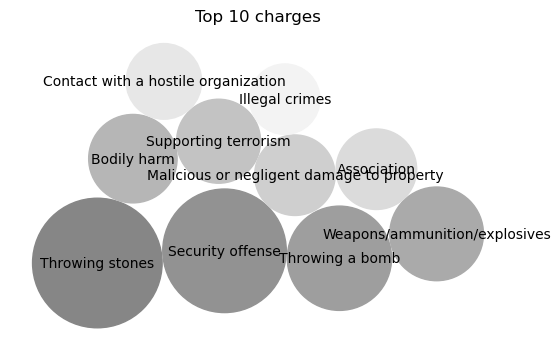

In [13]:
n_offenses = 10
colors = sns.color_palette('binary', n_offenses + 10)[:-10]
offense_count_data = {
    'offenses': [x.capitalize() for x in offense_counts.head(n_offenses).index],
    'counts': offense_counts.head(n_offenses).values,
    'color': colors[::-1]
}

bubble_chart = BubbleChart(area=offense_count_data['counts'],
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, offense_count_data['offenses'], offense_count_data['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Top {n_offenses} charges'.format(n_offenses=n_offenses))

# plt.savefig('figures/offenses.pdf', dpi=300, bbox_inches='tight')
plt.show()